In [4]:
%matplotlib inline

import os

import pandas as pd
import numpy as np

# Data and cleaning

In [5]:
#read in data
data_fp = 'lyrics.csv'
df = pd.read_csv(data_fp, engine='python')
df = df.drop('Source', axis  = 1)
df = df.dropna()

In [6]:
#put in word counts
df['Word Count'] = df['Lyrics'].str.split().str.len()

In [7]:
#remove soungs with word count of 0 or 1
display(df.loc[df['Word Count'] <= 1].head())
df = df[df['Word Count'] > 1]

,Rank,Song,Artist,Year,Lyrics,Word Count
2,3,i cant get no satisfaction,the rolling stones,1965,,0
17,18,the in crowd,ramsey lewis trio,1965,instrumental,1
177,78,love is a hurtin thing,lou rawls,1966,,0
179,80,gloria,shadows of knight,1966,,0
197,98,zorba the greek,herb alpert and the tijuana brass,1966,,0


In [8]:
#tokenize song lyrics, where '\x02' is START token and '\x03' is END token
df['tokens'] = ('\x02 ' + df['Lyrics'] + ' \x03').str.split()

In [9]:
df.head()

,Rank,Song,Artist,Year,Lyrics,Word Count,tokens
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,125,"[, sam, the, sham, miscellaneous, wooly, bull..."
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,204,"[, sugar, pie, honey, bunch, you, know, that,..."
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,152,"[, when, i, woke, up, this, morning, you, wer..."
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,232,"[, you, never, close, your, eyes, anymore, wh..."
5,6,downtown,petula clark,1965,when youre alone and life is making you lonel...,239,"[, when, youre, alone, and, life, is, making,..."


# N-gram model

In [10]:
# 1-gram base model

class UnigramLM(object):
    
    def __init__(self, tokens):
        """
        Initializes a Unigram languange model using a
        list of tokens. It trains the language model
        using 'train' and saves it to an attribute
        self.mdl.
        """
        self.mdl = self.train(tokens)
    
    def train(self, tokens):
        """
        Trains a unigram language model given a list of tokens.
        The output is a series indexed on distinct tokens, and
        values giving the probability of a token occuring
        in the language.
        """

        return pd.Series(tokens).value_counts(normalize = True)
    
    def sample(self, M):
        """
        sample selects tokens from the language model of length M, returning
        a string of tokens.
        """
        tokens = ''
        
        for _ in np.arange(M):
            tokens += np.random.choice(self.mdl.index, p = self.mdl.values) + ' '
        return tokens.strip()

In [11]:
# N-gram model

class NGramLM(object):
    
    def __init__(self, N, tokens):
        """
        Initializes a N-gram languange model using a
        list of tokens. It trains the language model
        using 'train' and saves it to an attribute
        self.mdl.
        """

        self.N = N
        ngrams = self.create_ngrams(tokens)

        self.ngrams = ngrams
        self.mdl = self.train(ngrams)

    def create_ngrams(self, tokens):
        """
        create_ngrams takes in a list of tokens and returns a list of N-grams. 
        """
        
        ngrams = []
        num_preceding = 0
        start_dist = 1
        for i in np.arange(len(tokens)):

            if tokens[i] == '\x02':
                gram = (tokens[i],) * self.N
                ngrams.append(gram)
                num_preceding = 0
                start_dist = 1
                continue        

            if tokens[i] == '\x03':
                k = 0
                while k < self.N:
                    gram = ()
                    for j in np.arange(self.N - 1 - k, 0, -1):
                        gram += (tokens[i - j],)
                    gram += ('\x03',) * (k + 1)
                    ngrams.append(gram)
                    k += 1
            elif num_preceding < self.N - 1:
                gram = (tokens[i - start_dist],) * (self.N - 1 - num_preceding)
                for j in np.arange(num_preceding, -1, -1):
                    gram += (tokens[i - j],)
                ngrams.append(gram)
                    
            else:
                gram = ()
                for j in np.arange(self.N - 1, -1, -1):
                    gram += (tokens[i - j],)
                ngrams.append(gram)

            num_preceding += 1
            start_dist += 1

        return ngrams

    
    def train(self, ngrams):
        """
        Trains a n-gram language model given a list of tokens.
        The output is a series indexed on distinct tokens, and
        values giving the probability of a token occuring
        in the language.
        """
      
        # Create ngram counts C(w_1, ..., w_n)
        ngram = pd.Series(self.ngrams)
        ngram_unigram = UnigramLM(ngram)
        
        # Create n-1 gram counts C(w_1, ..., w_(n-1))
        n1gram = ngram.apply(lambda x: x[:-1])
        n1gram_unigram = UnigramLM(n1gram)
        
        # Create the conditional probabilities
        prob = ngram.apply(lambda x: ngram_unigram.mdl[x]) / n1gram.apply(lambda y: n1gram_unigram.mdl[y])
        
        # Put it all together
        return pd.DataFrame({'ngram': ngram, 'n1gram': n1gram, 'prob': prob})

    def sample(self, length):
        """
        sample selects tokens from the language model of length M, returning
        a string of tokens.
        """
        
        # Use a helper function to generate sample tokens
        def pick_sample(n1gram, M, num_picked):
            
            if M > 0 and num_picked > self.mdl.shape[0] - (self.N-1)*2:
                return '\x03 ' * M

            if n1gram[-1] == '\x03':
                if M > 1:
                    return pick_sample(('\x02',)*(self.N-1), M-1, num_picked + 1)
                else:
                    return ''

            temp = self.mdl.loc[self.mdl['n1gram'] == n1gram].drop_duplicates()
            choices = temp['ngram'].apply(lambda x: x[-1]).tolist()
            p = temp['prob'].tolist()
            if M == 1:
                return np.random.choice(choices, p = p) + ' \x03'

            else:
                w = np.random.choice(choices, p = p)
                if w in set(['\x02', '\x03']):
                    return pick_sample(n1gram, M, num_picked)
                n1gram = (n1gram + (w,))[1:]
                return w + ' ' + pick_sample(n1gram, M-1, num_picked+1)
        
        # Tranform the tokens to strings recursively
        sampled_tokens = '\x02 '
        sampled_tokens += pick_sample(('\x02',)*(self.N-1), length, 0)
        return sampled_tokens.strip()

# Model application

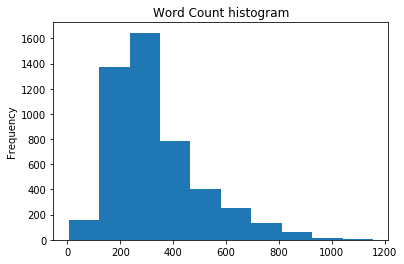

In [14]:
df['Word Count'].plot.hist(title = 'Word Count histogram')

In [15]:
def song_by_year(year, N = 3):
    """
    creates a sample song based on year and number of grams N
    If year is out of bounds, throw error
    
    """
    if type(year) == int:
        if year >= 1965 and year <= 2015:
            tokens = list([a for b in df[df['Year'] == year].tokens.tolist() for a in b])
            p = df[df['Year'] == year]['Word Count'].value_counts(normalize=True)
        else:
            raise TypeError("Year out of bounds")        
    else:
        raise TypeError("Invalid Year Input")
        
    model = NGramLM(N, tokens)
    song_length = np.random.choice(p.index, p = p.values)
    
    return model.sample(song_length)

In [16]:
song_by_year(2008)

'\x02 one two three four hey eh forever hey eh foreverits you and it feels like tonight tonight feels like tonight i kissed a girl im pretty sure you count me inive been awake for a model poppin that booty keep bumping titties just bouncin up and wait so close your eyes can do youll probably move right through me on my burner prepaid wireless we pack and deliver like ups trucks already going to hurt when it heals too oh itll all get better in time even though i really love you so sad and lonelyi remember when i believe it and that its good by the collar quick whoever havin problems with their record sales just holler tip if that dont mean im in that thing you know that youve been waitin for him to take you with you its going to hell just pumping that gasall i wanna no is sexy can i hit it like she want it she got it she got me ten feet off the lightsnow if she moves her body like a gangsta cause im trying to keep from goin under baby you believe in your eyes boy you better run for cove

In [17]:
def song_by_artist(artist, N = 3):
    """
    creates a sample song based on artist and number of grams N
    If no artist not in data, throw error
    
    """
    if type(artist) == str:
        if artist in set(df['Artist']):
            tokens = list([a for b in df[df['Artist'] == artist].tokens.tolist() for a in b])
            p = df[df['Artist'] == artist]['Word Count'].value_counts(normalize=True)
        else:
            raise TypeError("Artist not in data")        

    else:
        raise TypeError("Invalid Artist Input")
        
    model = NGramLM(N, tokens)
    song_length = np.random.choice(p.index, p = p.values)
    
    return model.sample(song_length)

In [18]:
song_by_artist('taylor swift')

'\x02 we were both young when i saw you standing thereit must have been the way you kissed me fell in love when i first saw you standing there it must have been the way you kissed me fell in love with a fear of fallin wondering why we bother with love if it never lastsi say can you feel this love is difficult but its real dont be afraid well make it out of the city lights on the first date man i didnt kiss him and i know its with mecant you see me again even if its torture dont say i didnt kiss her and i swear im gonna find someone someday who might actually treat me well this is me swallowing my pride standing in a nice dress staring at the sunset babe red lips and rosy cheeks say youll see me hows life tell me when its over if the high was worth the pain got a long list of exlovers theyll tell you to leave cause darling im a nightmare dressed like a daydreamso its gonna be alrightcause the players and you tell me about your dreams i think i know your story like i got home before i sa